Final Project: IEEE-CIS Fraud Detection Challenge (Kaggle)

COMP 6831 – Applied Machine Learning, Fall 2025

Philippe Laporte 24172957

In [1]:
# --- Config ----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

Data Exploration and EDA

In [2]:
# --- Training Data Loading and Joining ----

DATA_DIR = "data"

train_transaction_path = f"{DATA_DIR}/train_transaction.csv"
train_identity_path    = f"{DATA_DIR}/train_identity.csv"

# Load full datasets (no chunking)
train_tr = pd.read_csv(train_transaction_path)
train_id = pd.read_csv(train_identity_path)

print("train_transaction shape:", train_tr.shape)
print("train_identity shape:", train_id.shape)

# Merge identity into transaction on TransactionID
train = train_tr.merge(train_id, on="TransactionID", how="left")

print("Merged train shape:", train.shape)

print("\n=== Train .info() ===")
train.info()

print("\n=== First 5 rows of train ===")
print(train.head())

train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)
Merged train shape: (590540, 434)

=== Train .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB

=== First 5 rows of train ===
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ... 


=== isFraud value counts ===
isFraud
0    569877
1     20663
Name: count, dtype: int64

=== isFraud normalized ===
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


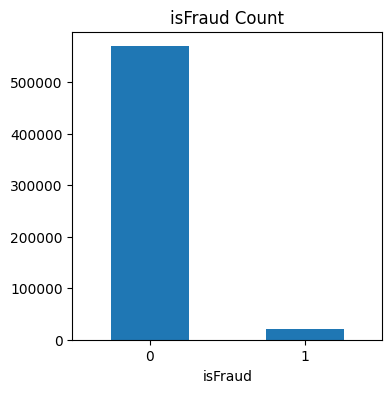

In [3]:
# --- Target variable stats ----

print("\n=== isFraud value counts ===")
print(train["isFraud"].value_counts())

print("\n=== isFraud normalized ===")
print(train["isFraud"].value_counts(normalize=True))

plt.figure(figsize=(4,4))
train["isFraud"].value_counts().plot(kind="bar")
plt.title("isFraud Count")
plt.xticks(rotation=0)
plt.savefig('isFraudCount.png', bbox_inches='tight')
plt.show()

In [4]:
# --- Missing values ----
     
def missing_values_table(df):
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100 * mis_val / len(df)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table.columns = ['n_missing', 'pct_missing']
    
    mis_val_table = mis_val_table[mis_val_table['n_missing'] > 0]
    
    mis_val_table = mis_val_table.sort_values('pct_missing', ascending=False)
    
    return mis_val_table

missing_train = missing_values_table(train)
print("\n=== Missing values (train) ===")
print(missing_train.head(20))


=== Missing values (train) ===
       n_missing  pct_missing
id_24     585793    99.196159
id_25     585408    99.130965
id_07     585385    99.127070
id_08     585385    99.127070
id_21     585381    99.126393
id_26     585377    99.125715
id_23     585371    99.124699
id_22     585371    99.124699
id_27     585371    99.124699
dist2     552913    93.628374
D7        551623    93.409930
id_18     545427    92.360721
D13       528588    89.509263
D14       528353    89.469469
D12       525823    89.041047
id_04     524216    88.768923
id_03     524216    88.768923
D6        517353    87.606767
id_33     517251    87.589494
id_10     515614    87.312290



Number of numeric columns: 403
Number of categorical columns: 31

Example numeric columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
Example categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28']
Categorical Overview

=== card4 value counts (top 10) ===
card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64


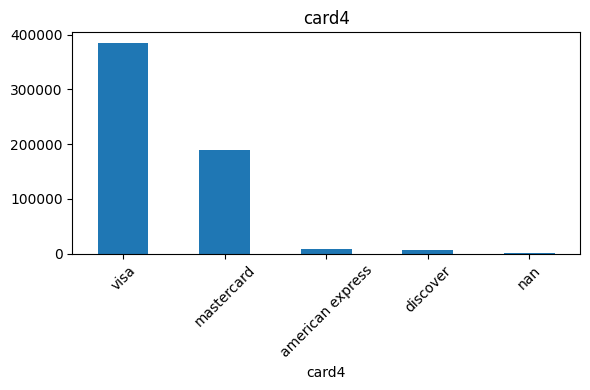

In [5]:
# --- Numerical vs Categorical Features ----

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumber of numeric columns: {len(num_cols)}")
print(f"Number of categorical columns: {len(cat_cols)}")

print("\nExample numeric columns:", num_cols[:20])
print("Example categorical columns:", cat_cols[:20])


print("Categorical Overview")

col = 'card4'

print(f"\n=== {col} value counts (top 10) ===")
print(train[col].value_counts(dropna=False).head(10))
        
plt.figure(figsize=(6,4))
train[col].value_counts(dropna=False).head(10).plot(kind='bar')
plt.title(f"{col}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{col}" + ".png", bbox_inches='tight')
plt.show()



=== Fraud rate by card4 ===
card4
discover            0.077282
visa                0.034756
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64


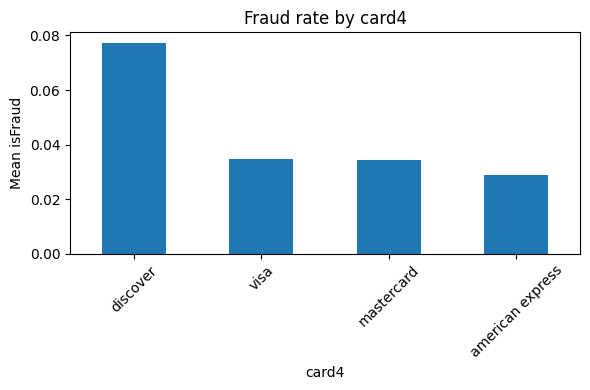


=== Fraud rate by card6 ===
card6
credit             0.066785
debit              0.024263
charge card        0.000000
debit or credit    0.000000
Name: isFraud, dtype: float64


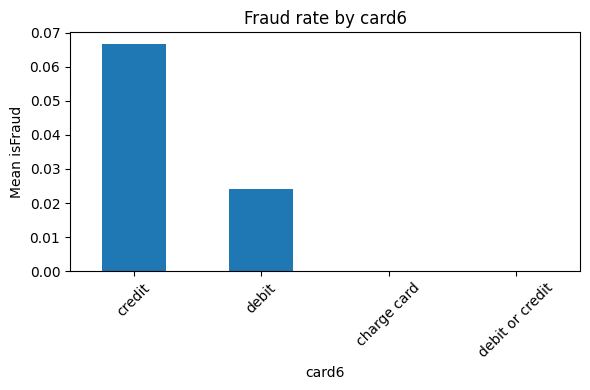


=== Fraud rate by DeviceType ===
DeviceType
mobile     0.101662
desktop    0.065215
Name: isFraud, dtype: float64


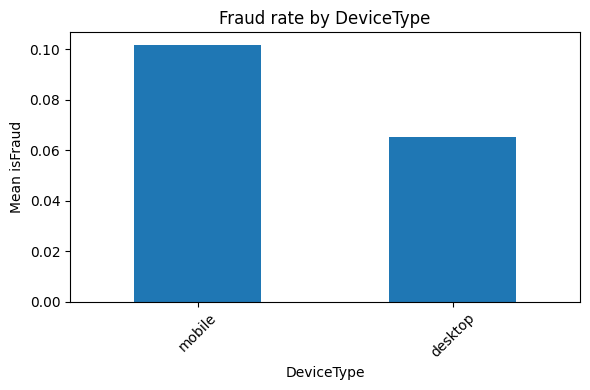

In [6]:
# --- Relationship Between Target and Some Features ----

def fraud_rate_by_feature(df, feature, target='isFraud', top_n=10):
    temp = df.groupby(feature)[target].mean().sort_values(ascending=False)
    print(f"\n=== Fraud rate by {feature} ===")
    print(temp.head(top_n))
    
    plt.figure(figsize=(6,4))
    temp.head(top_n).plot(kind='bar')
    plt.title(f"Fraud rate by {feature}")
    plt.ylabel("Mean isFraud")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for col in ['card4', 'card6', 'DeviceType']:
    if col in train.columns:
        fraud_rate_by_feature(train, col)

In [7]:
# --- Identity Coverage (How Many Transactions Have Identity Info?) ----

has_identity = train['id_01'].notnull() if 'id_01' in train.columns else train_id['TransactionID'].isin(train['TransactionID'])

pct_with_identity = has_identity.mean() * 100
print(f"\nPercentage of train rows with identity info (id_01 non-null): {pct_with_identity:.2f}%")

temp = train.assign(has_id=has_identity)
fraud_by_id_presence = temp.groupby('has_id')['isFraud'].mean()
print("\nFraud rate by presence of identity info:")
print(fraud_by_id_presence)


Percentage of train rows with identity info (id_01 non-null): 24.42%

Fraud rate by presence of identity info:
has_id
False    0.020939
True     0.078470
Name: isFraud, dtype: float64


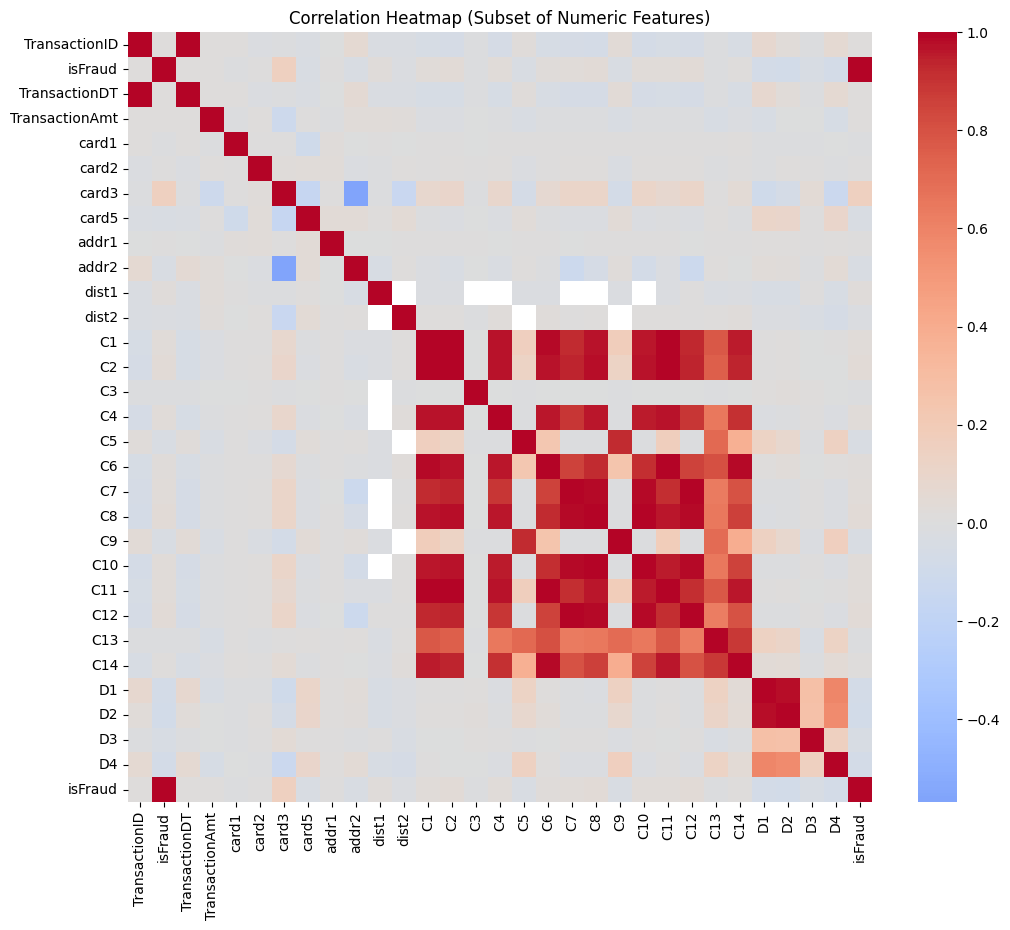

In [8]:
# --- Correlation Analysis (Subset of Numeric Features) ----

num_subset = num_cols[:30]
corr = train[num_subset + ["isFraud"]].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Correlation Heatmap (Subset of Numeric Features)")
plt.show()

Data Preprocessing and Cleaning 

On a Subsample (20k samples). Why do we subsample?

Full polynomial kernel requires ~2.5 TB of memory, so we draw ~20,000 samples (fits in my laptop's RAM)

In [9]:
# --- Data augmentation ---

# let's add a synthetic feature to help us out
train["has_identity"] = (~train["id_01"].isna()).astype(int)

# Remove Features with Extremely High Missing-ness
missing_ratio = train.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.95].index.tolist()

train = train.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)

# Label Encode Categorical Features. Impute missing categorical values as "missing"
cat_cols = train.select_dtypes(include="object").columns

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = train[col].fillna("missing")
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Separate targets
y = train["isFraud"]
train = train.drop("isFraud", axis=1)
X = train

# Reduce dataset to 20 000 samples for SVM feasibility
SAMPLE_SIZE = 20000
subset_idx = X.sample(SAMPLE_SIZE, random_state=42).index

X = X.loc[subset_idx]
y = y.loc[subset_idx]

print("\nSubsampled dataset shape:", X.shape)   

# Count fraud cases in the subsample
fraud_count = y.sum()
nonfraud_count = len(y) - fraud_count
fraud_pct = fraud_count / len(y)

print("\n=== Subsample Fraud Statistics ===")
print(f"Total samples: {len(y)}")
print(f"Fraud cases: {fraud_count}")
print(f"Non-fraud cases: {nonfraud_count}")
print(f"Fraud rate: {fraud_pct:.4f} ({fraud_pct*100:.2f}%)")

# Impute Missing Numerical Values     
num_cols = X.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="median")
X[num_cols] = imputer.fit_transform(X[num_cols])


Dropped columns: ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']

Subsampled dataset shape: (20000, 425)

=== Subsample Fraud Statistics ===
Total samples: 20000
Fraud cases: 714
Non-fraud cases: 19286
Fraud rate: 0.0357 (3.57%)


In [10]:
# --- Create same train-test split for all models ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)    

Training size: (16000, 425)
Test size: (4000, 425)



Model 1: Support Vector Machine (SVM)

Part I: Linear Kernel

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=  17.5s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=  22.1s
[CV] END .................svm__C=0.1, svm__class_weight=None; total time=  29.0s
[CV] END ...................svm__C=1, svm__class_weight=None; total time=  46.7s
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 1.2min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 1.3min
[CV] END ...................svm__C=1, svm__class_weight=None; total time= 1.4min
[CV] END ...............svm__C=1, svm__class_weight=balanced; total time= 1.5min
[CV] END ...................svm__C=1, svm__class_weight=None; total time= 1.5min
[CV] END .............svm__C=0.1, svm__class_weight=balanced; total time= 1.5min
[CV] END ...............svm__C=1, svm__class_weight=balanced; total time= 1.6min
[CV] END ...............svm__C=1, svm__class_weig

,param_svm__C,param_svm__class_weight,mean_test_score,std_test_score,rank_test_score
4,10.0,None,0.332123,0.014381,1
2,1.0,None,0.315097,0.027843,2
0,0.1,None,0.313088,0.019676,3
1,0.1,balanced,0.200173,0.008588,4
3,1.0,balanced,0.197606,0.007324,5
5,10.0,balanced,0.195791,0.005681,6



Best linear SVM params: {'svm__C': 10, 'svm__class_weight': None}
Best linear SVM F1: 0.33212253792144913


### Train Classification Report
```
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     15429
           1       0.93      0.31      0.46       571

    accuracy                           0.97     16000
   macro avg       0.95      0.65      0.72     16000
weighted avg       0.97      0.97      0.97     16000

```


Train Confusion Matrix:
[[15416    13]
 [  396   175]]

TRAIN Accuracy: 0.9744375


### Test Classification Report
```
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3857
           1       0.77      0.23      0.35       143

    accuracy                           0.97      4000
   macro avg       0.87      0.61      0.67      4000
weighted avg       0.96      0.97      0.96      4000

```


Test Confusion Matrix:
[[3847   10]
 [ 110   33]]

TEST Accuracy: 0.97

TRAIN AUC: 0.7859198890709934
TEST AUC: 0.7354514813679969


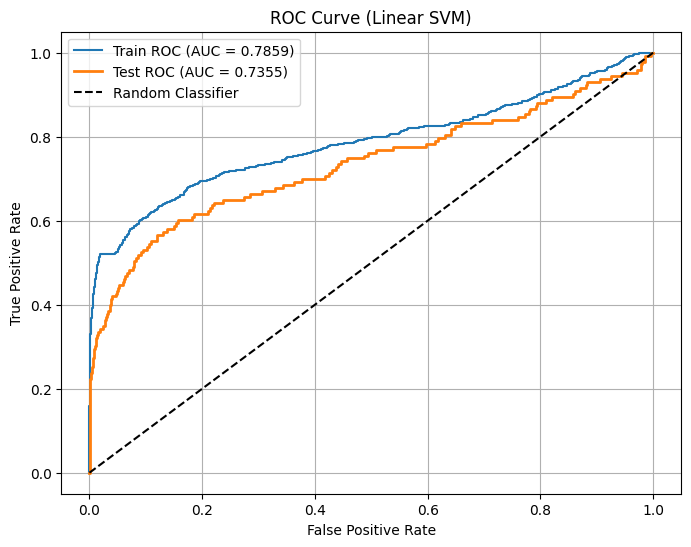

In [11]:
# Build SVM Pipeline

# Pipeline ensures:
# scaler.fit() happens on training data
# scaler.transform() happens automatically on test data

linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])


# Define Hyperparameter Grid

param_grid_linear = {
    "svm__C": [0.1, 1, 10],
    "svm__class_weight": [None, "balanced"]
}


# Cross-Validation Setup (for hyperparameter tuning only, only on training set

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search

grid_linear = GridSearchCV(
    estimator=linear_pipeline,
    param_grid=param_grid_linear,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_linear.fit(X_train, y_train)


# Extract all intermediate CV results
results_df = pd.DataFrame(grid_linear.cv_results_)

cols_to_show = [
    "param_svm__C",
    "param_svm__class_weight",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]

print("\n=== Intermediate Results (Linear SVM Grid Search) ===")
display(results_df[cols_to_show].sort_values("rank_test_score"))


# Best Parameters and Score

print("\nBest linear SVM params:", grid_linear.best_params_)
print("Best linear SVM F1:", grid_linear.best_score_)


# Evaluation

# Fit Best Model on Train Split
best_linear = grid_linear.best_estimator_
best_linear.fit(X_train, y_train)


# Train results
y_pred_train = best_linear.predict(X_train)

train_report = classification_report(y_train, y_pred_train)
display(Markdown(f"### Train Classification Report\n```\n{train_report}\n```"))

print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_train))

print("\nTRAIN Accuracy:", accuracy_score(y_train, y_pred_train))


# Test results

y_pred_test = best_linear.predict(X_test)

val_report = classification_report(y_test, y_pred_test)
display(Markdown(f"### Test Classification Report\n```\n{val_report}\n```"))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nTEST Accuracy:", accuracy_score(y_test, y_pred_test))



# ROC CURVE + AUC (Train & Test)


# Get decision function scores
y_train_scores = best_linear.decision_function(X_train)
y_test_scores = best_linear.decision_function(X_test)

# AUC
train_auc = roc_auc_score(y_train, y_train_scores)
test_auc = roc_auc_score(y_test, y_test_scores)

print("\nTRAIN AUC:", train_auc)
print("TEST AUC:", test_auc)

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)

plt.figure(figsize=(8, 6))

plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.4f})", linewidth=2)

plt.plot([0,1], [0,1], 'k--', label="Random Classifier")

plt.title("ROC Curve (Linear SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_linear_svm.png", bbox_inches='tight')
plt.show()

Part II: Polynomial Kernel

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale; total time=  42.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale; total time=  51.6s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale; total time=  55.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale; total time= 1.0min
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=0.01; total time= 1.2min
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=0.01; total time= 1.3min
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=scale; total time= 1.4min
[CV] END svm__C=1, svm__class_weight=None, svm__degree=2, svm__gamma=scale; total time= 1.3min
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=0.01; total time= 1.5min
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=3, svm__gamma=

,param_svm__C,param_svm__class_weight,param_svm__gamma,param_svm__degree,mean_test_score,std_test_score,rank_test_score
9,1.0,None,0.01,2,0.396159,0.035765,1
3,0.1,None,0.01,3,0.387925,0.032120,2
11,1.0,None,0.01,3,0.385366,0.043380,3
1,0.1,None,0.01,2,0.372127,0.042253,4
10,1.0,None,scale,3,0.362055,0.036896,5
8,1.0,None,scale,2,0.359369,0.033358,6
7,0.1,balanced,0.01,3,0.333427,0.016640,7
14,1.0,balanced,scale,3,0.323279,0.018253,8
5,0.1,balanced,0.01,2,0.308776,0.004080,9
13,1.0,balanced,0.01,2,0.307654,0.024452,10



Best polynomial SVM params: {'svm__C': 1, 'svm__class_weight': None, 'svm__degree': 2, 'svm__gamma': 0.01}
Best polynomial SVM F1: 0.39615875822772373


### Train Classification Report
```
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15429
           1       1.00      0.60      0.75       571

    accuracy                           0.99     16000
   macro avg       0.99      0.80      0.87     16000
weighted avg       0.99      0.99      0.98     16000

```


Train Confusion Matrix:
[[15429     0]
 [  231   340]]

TRAIN Accuracy: 0.9855625


### Test Classification Report
```
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3857
           1       0.57      0.32      0.41       143

    accuracy                           0.97      4000
   macro avg       0.78      0.66      0.70      4000
weighted avg       0.96      0.97      0.96      4000

```


Test Confusion Matrix:
[[3823   34]
 [  97   46]]

TEST Accuracy: 0.96725

TRAIN AUC: 0.9726693393238266
TEST AUC: 0.7392661784676304


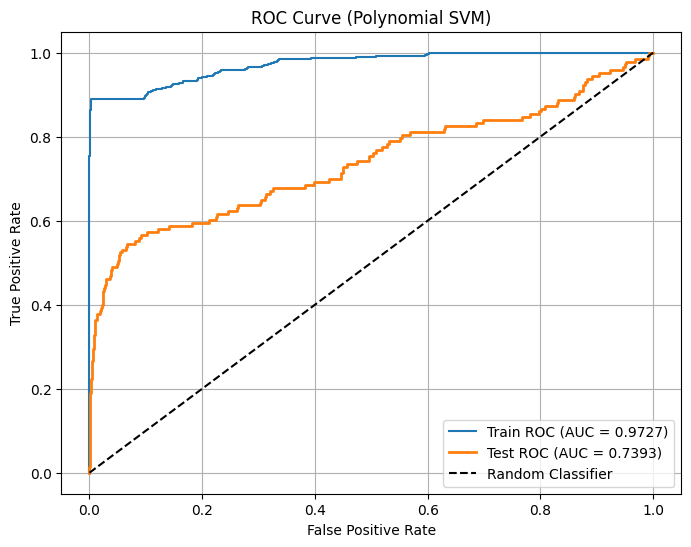

In [14]:
poly_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly"))
])

param_grid_poly = {
    "svm__C": [0.1, 1],
    "svm__gamma": ["scale", 0.01],
    "svm__degree": [2, 3],
    "svm__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_poly = GridSearchCV(
    estimator=poly_pipeline,
    param_grid=param_grid_poly,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_poly.fit(X, y)

poly_results_df = pd.DataFrame(grid_poly.cv_results_)

cols_to_show_poly = [
    "param_svm__C",
    "param_svm__class_weight",
    "param_svm__gamma",
    "param_svm__degree",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]

print("\n=== Intermediate Results (Polynomial SVM Grid Search) ===")
display(poly_results_df[cols_to_show_poly].sort_values("rank_test_score"))

print("\nBest polynomial SVM params:", grid_poly.best_params_)
print("Best polynomial SVM F1:", grid_poly.best_score_)


# Evaluation

# Fit Best Model on Train Split
best_poly = grid_poly.best_estimator_
best_poly.fit(X_train, y_train)


# Train results
y_pred_train = best_poly.predict(X_train)

train_report = classification_report(y_train, y_pred_train)
display(Markdown(f"### Train Classification Report\n```\n{train_report}\n```"))

print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_train))

print("\nTRAIN Accuracy:", accuracy_score(y_train, y_pred_train))


# Test results
    
y_pred_test = best_poly.predict(X_test)

val_report = classification_report(y_test, y_pred_test)
display(Markdown(f"### Test Classification Report\n```\n{val_report}\n```"))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print("\nTEST Accuracy:", accuracy_score(y_test, y_pred_test))



# ROC CURVE + AUC (Train & Test)


# Get decision function scores
y_train_scores = best_poly.decision_function(X_train)
y_test_scores = best_poly.decision_function(X_test)

# AUC
train_auc = roc_auc_score(y_train, y_train_scores)
test_auc = roc_auc_score(y_test, y_test_scores)

print("\nTRAIN AUC:", train_auc)
print("TEST AUC:", test_auc)

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)

plt.figure(figsize=(8, 6))

plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.4f})", linewidth=2)

plt.plot([0,1], [0,1], 'k--', label="Random Classifier")

plt.title("ROC Curve (Polynomial SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_poly_svm.png", bbox_inches='tight')
plt.show()

Model 2: Decision Tree

Fitting 3 folds for each of 12 candidates, totalling 36 fits
=== Intermediate Results (Decision Tree Grid Search) ===


,param_dt__criterion,param_dt__max_depth,mean_test_score,std_test_score,rank_test_score
2,gini,10,0.353283,0.006599,1
6,entropy,10,0.337760,0.002335,2
10,log_loss,10,0.337760,0.002335,2
3,gini,20,0.332624,0.010382,4
9,log_loss,5,0.325627,0.034053,5
5,entropy,5,0.325627,0.034053,5
7,entropy,20,0.318322,0.026290,7
11,log_loss,20,0.318322,0.026290,7
4,entropy,None,0.316109,0.025011,9
8,log_loss,None,0.316109,0.025011,9



Best Decision Tree params: {'dt__criterion': 'gini', 'dt__max_depth': 10}
Best Decision Tree F1: 0.35328337310537955


### Train Classification Report
```
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15429
           1       0.96      0.43      0.60       571

    accuracy                           0.98     16000
   macro avg       0.97      0.72      0.79     16000
weighted avg       0.98      0.98      0.98     16000

```

Train Confusion Matrix:
[[15420     9]
 [  323   248]]

TRAIN Accuracy: 0.979250


### Test Classification Report
```
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3857
           1       0.58      0.24      0.34       143

    accuracy                           0.97      4000
   macro avg       0.77      0.62      0.66      4000
weighted avg       0.96      0.97      0.96      4000

```

Test Confusion Matrix:
[[3832   25]
 [ 109   34]]

TEST Accuracy: 0.966500

TRAIN AUC: 0.9726693393238266
TEST AUC: 0.7392661784676304


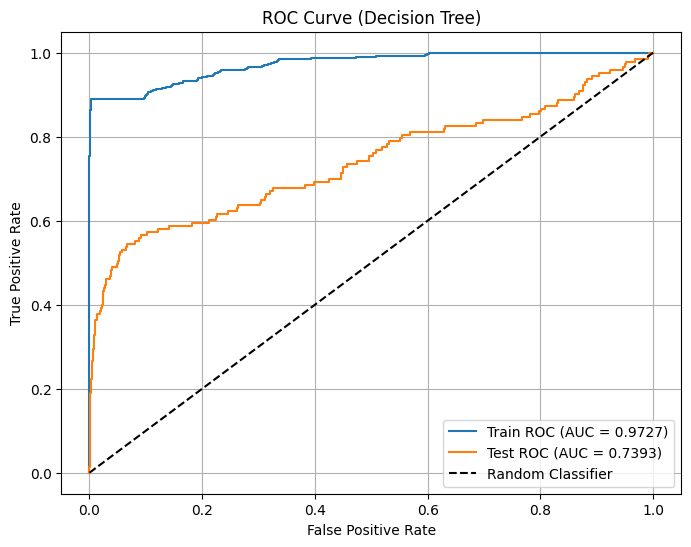

In [16]:
# Use the same train/test split as before


dt_pipe = Pipeline([
    ("dt", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "dt__criterion": ["gini", "entropy", "log_loss"],
    "dt__max_depth": [None, 5, 10, 20]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    scoring="f1",         
    cv=cv,                  
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)


# 2. Run Grid Search

dt_grid.fit(X_train, y_train)


# 3. Intermediate CV Results

print("=== Intermediate Results (Decision Tree Grid Search) ===")

results_dt = pd.DataFrame(dt_grid.cv_results_)

cols_to_show = [
    "param_dt__criterion",
    "param_dt__max_depth",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]

display(results_dt[cols_to_show].sort_values("rank_test_score"))

print("\nBest Decision Tree params:", dt_grid.best_params_)
print("Best Decision Tree F1:", dt_grid.best_score_)


# Evaluate Best Model on Train/Test
best_dt = dt_grid.best_estimator_


# Train metrics 
y_train_pred = best_dt.predict(X_train)

train_report = classification_report(y_train, y_train_pred)
display(Markdown(f"### Train Classification Report\n```\n{train_report}\n```"))

print("Train Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

train_accuracy = (y_train_pred == y_train).mean()
print(f"\nTRAIN Accuracy: {train_accuracy:.6f}")


# Test metrics
y_test_pred = best_dt.predict(X_test)

val_report = classification_report(y_test, y_test_pred)
display(Markdown(f"### Test Classification Report\n```\n{val_report}\n```"))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

test_accuracy = (y_test_pred == y_test).mean()
print(f"\nTEST Accuracy: {test_accuracy:.6f}")

# 5. ROC Curve and AUC

# Get decision function scores
y_train_scores = best_poly.decision_function(X_train)
y_test_scores = best_poly.decision_function(X_test)

# AUC
train_auc = roc_auc_score(y_train, y_train_scores)
test_auc = roc_auc_score(y_test, y_test_scores)

print("\nTRAIN AUC:", train_auc)
print("TEST AUC:", test_auc)

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)


plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")

plt.title("ROC Curve (Decision Tree)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_decision_tree.png", bbox_inches='tight')
plt.show()